In [1]:
from tensorflow.keras.applications import MobileNetV2                     #Base model --- Transfer learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator       #for data augmentation
from tensorflow.keras import layers                                       #used for head_model architecture construction for fine tuning
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input   #preprocessing the input to meet requried way of the baseModel input
from tensorflow.keras.preprocessing.image import img_to_array             #load_img=>img_to_array=>preprocess_input[incase of mobileNetV2]
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split                     #for splitting data 
from tensorflow.keras.utils import to_categorical                        #labelBinarizer=>to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report                        #all 4 types of errors with F_score and precision
from imutils import paths                                                #for constructing the images_path from the directory
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config=ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.5
config.gpu_options.allow_growth =True
session=InteractiveSession(config=config)

In [3]:
# !pip install imutils

In [4]:
dataset=os.path.join(os.getcwd(),'./dataset/')
model_path=os.path.join(os.getcwd(),'./mask_detector.model')

In [5]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
from imutils import paths
img_ls=list(paths.list_images(dataset))
# img_ls is a list of all the image[training data] paths. 

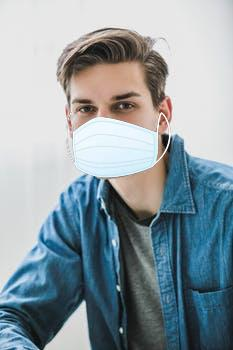

In [7]:
load_img(img_ls[2])
#loads the image and doesn't return into the array form. to get this work done we use img_to_array

In [8]:
print('---technique of label extraction---')
print('name of an image file : ',img_ls[2])   
print('after splitting : ',(img_ls[2]).split(os.path.sep))    #os.path.sep is very imp. as it separates each subsequent directory
print('label filtering : ',(img_ls[2]).split(os.path.sep)[-2])
print('label filtering : ', (img_ls[2]).split(os.path.sep)[-2].split('/'))
print('label : ', (img_ls[2]).split(os.path.sep)[-2].split('/')[2])

---technique of label extraction---
name of an image file :  C:\Users\sidzs\DL Coursera\Tensorflow\P-6 Mask detection\./dataset/with mask\10-with-mask.jpg
after splitting :  ['C:', 'Users', 'sidzs', 'DL Coursera', 'Tensorflow', 'P-6 Mask detection', './dataset/with mask', '10-with-mask.jpg']
label filtering :  ./dataset/with mask
label filtering :  ['.', 'dataset', 'with mask']
label :  with mask


In [9]:
#data preparation
data=[]
labels=[]
for img in img_ls:
    label=(img).split(os.path.sep)[-2].split('/')[2]    #technique to extract the respective label of an image
    labels.append(label)
    
    img=load_img(img,target_size=(224,224))   #load the img
    img=img_to_array(img)                     #convert into the array form
    img=preprocess_input(img)                 #convert into the way the input is requried for the base Model[mobileNetV2]
    data.append(img)
    
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [10]:
lb=LabelBinarizer()               #intialization
labels=lb.fit_transform(labels)   #obtaining the one_hot encoding for the labels
labels=to_categorical(labels)     #converting the labels into one_hot encoding
# [1,0]=> mask
# [0,1]=>without mask

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,stratify=labels, random_state=42)  #stratify makes sure that spilting is even for unbalanced data by splitting evenly for each classes 

aug=ImageDataGenerator(width_shift_range=0.2,     #intializing the data augmentation
                      height_shift_range=0.2,
                      fill_mode='nearest',
                      horizontal_flip=True,
                      shear_range=0.15,
                      zoom_range=0.15,
                      rotation_range=20)

In [12]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=layers.Input(shape=(224,224,3)))  #baseModel---locked layers

headModel=baseModel.output
headModel=layers.AveragePooling2D((7,7))(headModel)
headModel=layers.Flatten()(headModel)
headModel=layers.Dense(128,activation='relu')(headModel)
headModel=layers.Dropout(0.5)(headModel)
headModel=layers.Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)   #our own architecture on top of the baseModel[fine tuned base model]

for layer in baseModel.layers:
    layer.trainable=False

In [ ]:
print('[INFO] compiling model...')
opt=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

print('[INFO] training the head of the model...')
H=model.fit(x=aug.flow(X_train,y_train,batch_size=BS),       #fine-tuning the model
           steps_per_epoch=len(X_train)//BS,
            validation_data=(X_test,y_test),
           validation_steps=len(X_test)//BS,
           epochs=EPOCHS)

[INFO] compiling model...
[INFO] training the head of the model...
Epoch 1/20
34/34 [==============================] - 50s 629ms/step - loss: 0.7889 - accuracy: 0.6058 - val_loss: 0.2703 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 14s 419ms/step - loss: 0.3034 - accuracy: 0.9376 - val_loss: 0.1352 - val_accuracy: 0.9746
Epoch 3/20
34/34 [==============================] - 19s 579ms/step - loss: 0.1568 - accuracy: 0.9694 - val_loss: 0.0853 - val_accuracy: 0.9819
Epoch 4/20
34/34 [==============================] - 19s 563ms/step - loss: 0.1023 - accuracy: 0.9803 - val_loss: 0.0610 - val_accuracy: 0.9855
Epoch 5/20
34/34 [==============================] - 19s 549ms/step - loss: 0.0816 - accuracy: 0.9850 - val_loss: 0.0531 - val_accuracy: 0.9855
Epoch 6/20
34/34 [==============================] - 18s 536ms/step - loss: 0.0658 - accuracy: 0.9902 - val_loss: 0.0405 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 18s 531ms/step - loss: 

In [134]:
print('[INFO] evaluating network...')
predIndxs=model.predict(X_test,batch_size=BS)

# predIndxs=np.argmax(predIndxs,axis=1)   #now the predIndxs stores the index of the label which has highest probability

print(classification_report(y_true=y_test.argmax(axis=1),y_pred=np.argmax(predIndxs,axis=1),target_names=['with mask','without mask']))
# y_true = indxs of max value along each row
# y_pred = indxs of max value along each row[every test case prediction] of prediction


[INFO] evaluating network...
              precision    recall  f1-score   support

   with mask       1.00      1.00      1.00       138
without mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [138]:
print('[INFO] saving mask detection model to disk...')
model.save(model_path,save_format='h5')
#note here the model_path contains the file name as mask_detector.model

[INFO] saving mask detection model to disk...


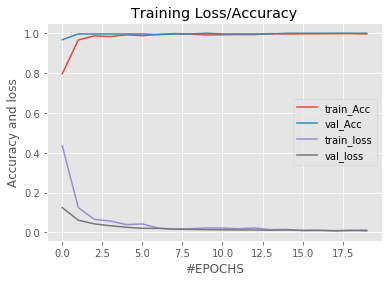

In [136]:
N=EPOCHS

# plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N),H.history['accuracy'],label='train_Acc')
plt.plot(np.arange(0,N),H.history['val_accuracy'],label='val_Acc')
plt.plot(np.arange(0,N),H.history['loss'],label='train_loss')
plt.plot(np.arange(0,N),H.history['val_loss'],label='val_loss')
plt.title('Training Loss/Accuracy')
plt.xlabel('#EPOCHS')
plt.ylabel('Accuracy and loss')
plt.legend(loc='best')
plot_path=os.path.join(os.getcwd(),'./plot.png')   #note here the path is given as .png format
plt.savefig(plot_path)